In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import rdkit
from rdkit import Chem
from posebusters import PoseBusters
import json
from tqdm import tqdm
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from utils import parse_molecule_with_coordinates

# This enables inline rendering of molecules
IPythonConsole.ipython_useSVG=True 

/auto/home/menuab/miniforge3/envs/titan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
test_mols_path = "/mnt/sxtn2/chem/GEOM_data/geom_processed/test_smiles_corrected.csv"
test_mols_json = "/auto/home/menuab/code/3DMolGen/drugs_test_inference.jsonl"
# with open(test_mols_path, 'r') as f:
#     test_mols = [m.split(',')[-2:] for m in f.readlines()][1:]
# test_mols = [(int(m[0]), m[1].strip()) for m in test_mols]
with open(test_mols_json,'r') as f:
    test_mols = [json.loads(d) for d in f]

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [13]:
7//3

2

In [7]:
cart_1x_path = "/nfs/h100/raid/chem/checkpoints/hf/yerevann/Llama-3.2-1B_conformers/c037e75255bc41c19c716939/step-4500"
cart_2x_path = "/nfs/h100/raid/chem/checkpoints/hf/yerevann/Llama-3.2-1B_conformers/d267db61f57d4b428baa604a/step-9000"
cart_4x_path = "/nfs/h100/raid/chem/checkpoints/hf/yerevann/Llama-3.2-1B_conformers/3408e9758572478c80393771/step-18000"
cart_6e_path = "/nfs/h100/raid/chem/checkpoints/hf/yerevann/Llama-3.2-1B_conformers/301b8328481243c6aa8d8003/step-27000"
cart_8e_path = "/nfs/h100/raid/chem/checkpoints/hf/yerevann/Llama-3.2-1B_conformers/c13311b27056459eaccf5877/step-36000"



tokenizer  = AutoTokenizer.from_pretrained("/auto/home/menuab/code/YNNtitan/torchtitan/tokenizers/Llama-3.2-chem-1B-v1")
model = AutoModelForCausalLM.from_pretrained(cart_8e_path).to("cuda:1")
model.dtype, model.device

(torch.float32, device(type='cuda', index=1))

In [8]:
canonical_smiles = '[H][O][C]1=[C]([C](=[N][C]([H])([H])[C]([H])([H])[c]2[c]([H])[c]([H])[c]([H])[c]([H])[c]2[H])[C]([H])([H])[H])[C](=[O])[S][C]1([H])[H]'
prompt = f"[SMILES]{canonical_smiles}[/SMILES]"
prompt = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).to(model.device).input_ids
output = model.generate(prompt, max_new_tokens=2000, eos_token_id=128329, do_sample=False)
output = tokenizer.batch_decode(output)
print(output)

/auto/home/menuab/miniforge3/envs/titan/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/auto/home/menuab/miniforge3/envs/titan/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['<|begin_of_text|>[SMILES][H][O][C]1=[C]([C](=[N][C]([H])([H])[C]([H])([H])[c]2[c]([H])[c]([H])[c]([H])[c]([H])[c]2[H])[C]([H])([H])[H])[C](=[O])[S][C]1([H])[H][/SMILES][CONFORMER][H<-0.8480,-1.1391,0.9481>][O<-0.1931,-1.9029,0.8386>][C<0.9329,-1.3611,0.4331>]1=[C<1.1171,-0.0286,0.1816>]([C<0.0276,0.9315,0.3531>](=[N<-1.0611,0.4471,0.8155>][C<-2.2656,1.1930,1.0085>]([H<-2.1049,2.2708,1.1256>])([H<-2.7242,0.8047,1.9237>])[C<-3.2247,0.9459,-0.1740>]([H<-2.7889,1.3798,-1.0757>])([H<-4.1674,1.4525,0.0380>])[c<-3.4419,-0.5274,-0.3560>]2[c<-2.5919,-1.2689,-1.1675>]([H<-1.8025,-0.7679,-1.7102>])[c<-2.7506,-2.6379,-1.2899>]([H<-2.0830,-3.2017,-1.9254>])[c<-3.7625,-3.2834,-0.6003>]([H<-3.8877,-4.3519,-0.6959>])[c<-4.6157,-2.5533,0.2099>]([H<-5.4095,-3.0515,0.7476>])[c<-4.4535,-1.1852,0.3333>]2[H<-5.1217,-0.6185,0.9669>])[C<0.2587,2.3626,-0.0181>]([H<0.4801,2.9449,0.8760>])([H<1.1041,2.4501,-0.6929>])[H<-0.6279,2.7841,-0.4879>])[C<2.4411,0.3980,-0.2489>](=[O<2.8360,1.5099,-0.4881>])[S<3.5331,-1

In [ ]:
# file = open('drugs_test_mols_inference.jsonl','w') 
ref, gen, incs = [], [], []
inc = 0
import re
for en, mol_dict in enumerate(tqdm(test_mols)):
    canonical_smiles = mol_dict["canonical_smiles"]
    canonical_smiles = '[H][O][C]1=[C]([C](=[N][C]([H])([H])[C]([H])([H])[c]2[c]([H])[c]([H])[c]([H])[c]([H])[c]2[H])[C]([H])([H])[H])[C](=[O])[S][C]1([H])[H]'

    geom_smiles = mol_dict["geom_smiles"]
    num_generations = mol_dict["num_confs"] * 2
    print(f"mol num: {en+1} generating {num_generations} conformers for {geom_smiles}")    
    generations = []
    prompt = f"[SMILES]{canonical_smiles}[/SMILES]"
    prompt = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).to(model.device).input_ids
    
    # output = model.generate(prompt, max_new_tokens=2000, eos_token_id=128329, do_sample=False)
    output = model.generate(prompt, max_length=2000, eos_token_id=128329, 
                        # num_beams=10,
                        # num_beam_groups=2,
                        # diversity_penalty=1.1,
                        num_return_sequences=2, 
                        do_sample=True,
                        top_p=0.90,
                        temperature=0.8,
                        # top_k=3
                        )
    print(f"len prompt toks: {len(prompt[0])}, len gen toks: {len(output[0])-len(prompt[0])}")
    output = tokenizer.batch_decode(output)
    # print("raw output: ", output)
    # print("canonical_smiles: ", canonical_smiles)
    # display(Chem.MolFromSmiles(canonical_smiles))
    for out in output:
        generated_conformer = out[out.find("[CONFORMER]")+len("[CONFORMER]"):out.find("[/CONFORMER]")]
        # print(generated_conformer)
        generated_smiles = re.sub(r'<[^>]*>', '', generated_conformer)
        if generated_smiles == canonical_smiles:
            ref.append(geom_smiles)
            gen.append(generated_smiles)
            print(f"{canonical_smiles=}")
            print(f"{generated_smiles=}")
            print(f"{out=}")
            sample = {
                "geom_smiles": geom_smiles,
                "generated_conformer": generated_conformer
            }
            file.write(f"{json.dumps(sample)}\n")
        else:
            print("smiles didn't match for ")
            print(f"{canonical_smiles=}")
            print(f"{generated_smiles=}")
            print(out)
            incs.append(out)
            inc += 1
        # print("generated_smiles: ", generated_smiles)
        # display(Chem.MolFromSmiles(generated_smiles))
    print('----------------------')
    file.close()
    break
    # if en==100:
    #     break
    

  0%|          | 0/1000 [00:00<?, ?it/s]

mol num: 1 generating 138 conformers for C#CCNC(=O)C1=C[C@@H](c2ccc(Br)cc2)C[C@@H](OCc2ccc(CO)cc2)O1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
  0%|          | 0/1000 [00:11<?, ?it/s]

len prompt toks: 88, len gen toks: 602
canonical_smiles='[H][O][C]1=[C]([C](=[N][C]([H])([H])[C]([H])([H])[c]2[c]([H])[c]([H])[c]([H])[c]([H])[c]2[H])[C]([H])([H])[H])[C](=[O])[S][C]1([H])[H]'
generated_smiles='[H][O][C]1=[C]([C](=[N][C]([H])([H])[C]([H])([H])[c]2[c]([H])[c]([H])[c]([H])[c]([H])[c]2[H])[C]([H])([H])[H])[C](=[O])[S][C]1([H])[H]'
out='<|begin_of_text|>[SMILES][H][O][C]1=[C]([C](=[N][C]([H])([H])[C]([H])([H])[c]2[c]([H])[c]([H])[c]([H])[c]([H])[c]2[H])[C]([H])([H])[H])[C](=[O])[S][C]1([H])[H][/SMILES][CONFORMER][H<-2.1227,-2.4066,0.0171>][O<-3.0615,-2.0513,0.0322>][C<-2.9815,-0.7348,0.0014>]1=[C<-1.9039,0.0974,-0.0384>]([C<-0.5432,-0.4122,-0.0478>](=[N<0.4296,0.4126,-0.1234>][C<1.8135,0.0420,-0.1334>]([H<1.9969,-0.8204,-0.7864>])([H<2.1302,-0.2397,0.8801>])[C<2.6484,1.2332,-0.6214>]([H<2.4324,1.4031,-1.6782>])([H<2.3361,2.1208,-0.0685>])[c<4.1106,0.9633,-0.4145>]2[c<4.7994,0.1287,-1.2863>]([H<4.2861,-0.2955,-2.1375>])[c<6.1366,-0.1581,-1.0765>]([H<6.6606,-0.8065,-1.7634>]

In [6]:
m_gen = '[H<-0.0541,-1.9089,0.0001>][O<-0.9993,-2.2537,0.0001>][C<-1.7999,-1.2063,0.0001>]1=[C<-1.4564,0.1106,0.0001>]([C<-0.0788,0.5689,0.0001>](=[N<0.8417,-0.3277,0.0001>][C<2.2485,-0.0474,0.0001>]([H<2.5225,0.5473,0.8810>])([H<2.5319,0.5279,-0.8907>])[C<3.0100,-1.3801,0.0118>]([H<2.7208,-1.9349,0.9052>])([H<2.7059,-1.9615,-0.8595>])[c<4.4899,-1.1329,0.0004>]2[c<5.2423,-1.3378,1.1489>]([H<4.7600,-1.7082,2.0424>])[c<6.6015,-1.0774,1.1557>]([H<7.1753,-1.2451,2.0552>])[c<7.2245,-0.6015,0.0147>]([H<8.2852,-0.3985,0.0200>])[c<6.4818,-0.3901,-1.1344>]([H<6.9632,-0.0206,-2.0281>])[c<5.1237,-0.6519,-1.1403>]2[H<4.5471,-0.4887,-2.0396>])[C<0.1665,2.0521,-0.0001>]([H<1.2285,2.2721,-0.0001>])([H<-0.2910,2.4999,-0.8815>])[H<-0.2959,2.5005,0.8790>])[C<-2.6091,1.0094,0.0001>](=[O<-2.6401,2.2087,0.0001>])[S<-4.1199,0.0224,-0.0001>][C<-3.2319,-1.5780,-0.0001>]1([H<-3.5528,-2.1773,-0.8520>])[H<-3.4629,-2.1250,0.9149>]'

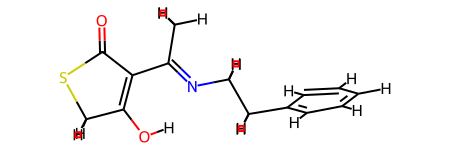

In [7]:
parse_molecule_with_coordinates(m_gen)

import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
import numpy as np

# Set style for scientific publication
plt.style.use('seaborn-v0_8-paper')

# Data
temperatures = [0.8, 0.9, 1.0, 1.1]
amr_p = [0.75, 0.72, 0.68, 0.63]  # Example precision values
amr_r = [0.62, 0.67, 0.71, 0.73]  # Example recall values

# Create figure with specified size
plt.figure(figsize=(5, 6))

# Plot lines with scientific color scheme
plt.plot(temperatures, amr_p, color='#2166ac', marker='o', linewidth=2, label='AMR-P')
plt.plot(temperatures, amr_r, color='#b2182b', marker='s', linewidth=2, label='AMR-R')

# Customize the plot
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('AMR Metrics vs Temperature', fontsize=14, pad=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Set axis limits with some padding
plt.xlim(0.75, 1.15)
plt.ylim(0.6, 0.8)

# Add legend
plt.legend(frameon=True, loc='upper right', fontsize=10)

# Adjust layout
plt.tight_layout()

# Save figure
<!-- plt.savefig('amr_metrics.png', dpi=300, bbox_inches='tight') -->

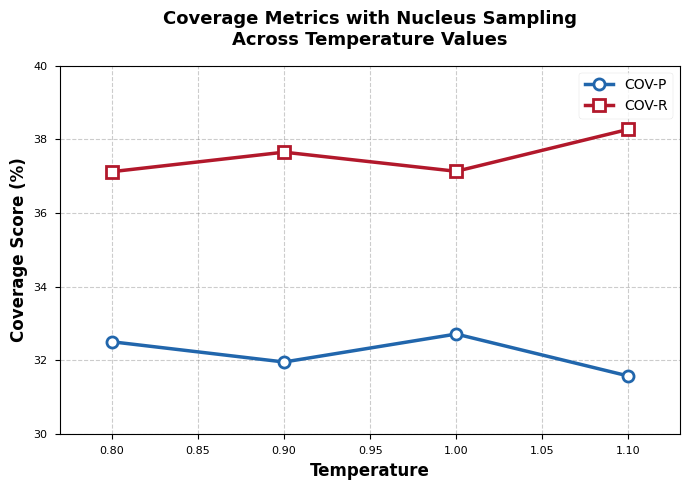

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Set style for scientific publication
plt.style.use('seaborn-v0_8-paper')

# Data
temperatures = [0.8, 0.9, 1.0, 1.1]
cov_p = [32.5,31.95,32.71,31.57]  # Example precision values
cov_r = [37.12,37.65, 37.13,38.27]  # Example recall values

# Create figure with specified size
plt.figure(figsize=(7, 5))

plt.plot(temperatures, cov_p, color='#2166ac', marker='o', linewidth=2.5, 
         label='COV-P', markersize=8, markerfacecolor='white', 
         markeredgewidth=2, markeredgecolor='#2166ac')
plt.plot(temperatures, cov_r, color='#b2182b', marker='s', linewidth=2.5, 
         label='COV-R', markersize=8, markerfacecolor='white', 
         markeredgewidth=2, markeredgecolor='#b2182b')

# Customize the plot
plt.xlabel('Temperature', fontsize=12, fontweight='bold')
plt.ylabel('Coverage Score (%)', fontsize=12, fontweight='bold')
plt.title('Coverage Metrics with Nucleus Sampling\nAcross Temperature Values', 
          fontsize=13, pad=15, fontweight='bold')

# Add grid but make it lighter
plt.grid(True, linestyle='--', alpha=0.4, color='gray')

# Set axis limits with appropriate padding
plt.ylim(30, 40)
plt.xlim(0.77, 1.13)

# Add legend
plt.legend(frameon=True, loc='upper right', fontsize=10)

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig('coverage_metrics.pdf', dpi=300, bbox_inches='tight')

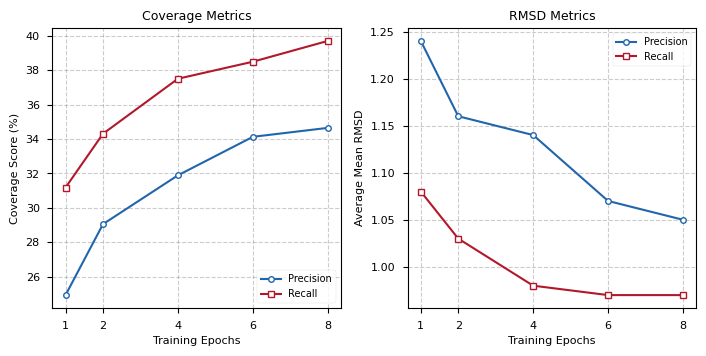

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-paper')

# Data
epochs = [1, 2, 4, 6, 8]
cov_p = [24.92, 29.05, 31.89, 34.13, 34.65]
cov_r = [31.18, 34.31, 37.51, 38.5, 39.71]
amr_p = [1.24, 1.16, 1.14, 1.07, 1.05]
amr_r = [1.08, 1.03, 0.98, 0.97, 0.97]

# Create figure - typical LaTeX linewidth is about 7 inches
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))

# Plot Coverage (left subplot)
ax1.plot(epochs, cov_p, color='#2166ac', marker='o', linewidth=1.5, 
         label='Precision', markersize=4, markerfacecolor='white', 
         markeredgewidth=1, markeredgecolor='#2166ac')
ax1.plot(epochs, cov_r, color='#b2182b', marker='s', linewidth=1.5, 
         label='Recall', markersize=4, markerfacecolor='white', 
         markeredgewidth=1, markeredgecolor='#b2182b')

# Plot RMSD (right subplot)
ax2.plot(epochs, amr_p, color='#2166ac', marker='o', linewidth=1.5, 
         label='Precision', markersize=4, markerfacecolor='white', 
         markeredgewidth=1, markeredgecolor='#2166ac')
ax2.plot(epochs, amr_r, color='#b2182b', marker='s', linewidth=1.5, 
         label='Recall', markersize=4, markerfacecolor='white', 
         markeredgewidth=1, markeredgecolor='#b2182b')

# Customize left subplot (Coverage)
ax1.set_xlabel('Training Epochs', fontsize=8)
ax1.set_ylabel('Coverage Score (%)', fontsize=8)
ax1.set_title('Coverage Metrics', fontsize=9)
ax1.grid(True, linestyle='--', alpha=0.4, color='gray')
ax1.set_xticks(epochs)
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.legend(frameon=True, loc='lower right', fontsize=7)

# Customize right subplot (RMSD)
ax2.set_xlabel('Training Epochs', fontsize=8)
ax2.set_ylabel('Average Mean RMSD', fontsize=8)
ax2.set_title('RMSD Metrics', fontsize=9)
ax2.grid(True, linestyle='--', alpha=0.4, color='gray')
ax2.set_xticks(epochs)
ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.legend(frameon=True, loc='upper right', fontsize=7)

# Adjust layout with minimal padding
plt.tight_layout(pad=0.5, w_pad=1.0)

# Save figure in PDF format
plt.savefig('training_metrics.pdf', format='pdf', 
            bbox_inches='tight', pad_inches=0.02)

In [ ]:
COV-R= [38.92,39.52,39.4,38.47,38.4,38.81,38.71,39.3,37.74,37.55,39.32,37.96]
cov_p=[31.39,30.79,30.8,30.9,30.03,30.98,31.21,30.61,30.55,30.46,31.37,31.47,31.44,30.45]
hyp = [(0.5,1.0),(0.5,1.1),(0.5,1.2),(0.5,1.3),(1.0,1.0),(1.0,1.1),(1.0,1.2),(1.0,1.3),(2.0,1.0),(2.0,1.1),(2.0,1.2),(2.0,1.3),]

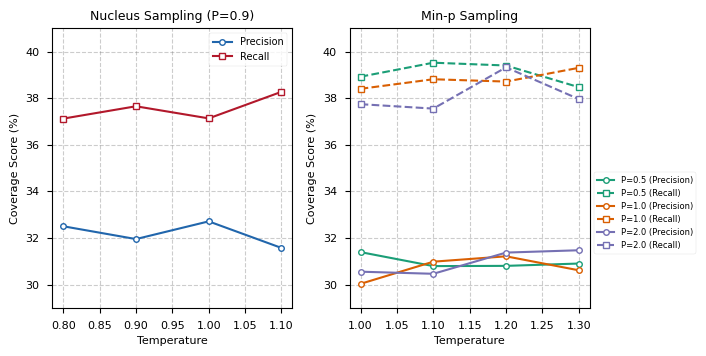

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-paper')

# Data for min-p sampling
cov_r_min_p = [38.92,39.52,39.4,38.47,38.4,38.81,38.71,39.3,37.74,37.55,39.32,37.96]
cov_p_min_p = [31.39,30.79,30.8,30.9,30.03,30.98,31.21,30.61,30.55,30.46,31.37,31.47]
p_values = [0.5, 1.0, 2.0]
temps = [1.0, 1.1, 1.2, 1.3]

# Data for nucleus sampling
temperatures_nucleus = [0.8, 0.9, 1.0, 1.1]
cov_p_nucleus = [32.5, 31.95, 32.71, 31.57]
cov_r_nucleus = [37.12, 37.65, 37.13, 38.27]

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))

# Plot nucleus sampling results (left subplot)
ax1.plot(temperatures_nucleus, cov_p_nucleus, color='#2166ac', marker='o', 
         linewidth=1.5, label='Precision', markersize=4, markerfacecolor='white', 
         markeredgewidth=1)
ax1.plot(temperatures_nucleus, cov_r_nucleus, color='#b2182b', marker='s', 
         linewidth=1.5, label='Recall', markersize=4, markerfacecolor='white', 
         markeredgewidth=1)

# Plot min-p sampling results (right subplot)
colors_p = ['#1b9e77', '#d95f02', '#7570b3']  # Distinct palette for p values
for i, p in enumerate(p_values):
    idx = i * 4
    ax2.plot(temps, cov_p_min_p[idx:idx+4], color=colors_p[i], marker='o', 
             linewidth=1.5, markersize=4, markerfacecolor='white', 
             markeredgewidth=1, label=f'P={p} (Precision)')
    ax2.plot(temps, cov_r_min_p[idx:idx+4], color=colors_p[i], marker='s', 
             linewidth=1.5, markersize=4, markerfacecolor='white', 
             markeredgewidth=1, linestyle='--', label=f'P={p} (Recall)')

# Customize left subplot (nucleus)
ax1.set_xlabel('Temperature', fontsize=8)
ax1.set_ylabel('Coverage Score (%)', fontsize=8)
ax1.set_title('Nucleus Sampling (P=0.9)', fontsize=9)
ax1.grid(True, linestyle='--', alpha=0.4, color='gray')
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.legend(frameon=True, loc='best', fontsize=7)
ax1.set_ylim(29, 41)

# Customize right subplot (min-p)
ax2.set_xlabel('Temperature', fontsize=8)
ax2.set_ylabel('Coverage Score (%)', fontsize=8)
ax2.set_title('Min-p Sampling', fontsize=9)
ax2.grid(True, linestyle='--', alpha=0.4, color='gray')
ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.legend(frameon=True, loc='best', bbox_to_anchor=(1, 0.5), fontsize=6)
ax2.set_ylim(29, 41)

# Adjust layout
plt.tight_layout(pad=0.5, w_pad=1.0)

# Save figure in PDF format
plt.savefig('sampling_comparison.pdf', format='pdf', 
            bbox_inches='tight', pad_inches=0.02)